In [ ]:
import os
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  img = tf.image.resize(img, (422, 512))
  img = img[tf.newaxis, :]
  return img

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

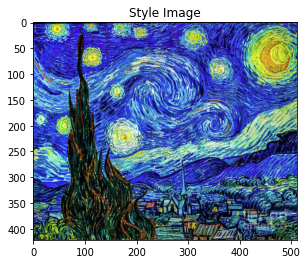

In [ ]:
style_image = load_img("/content/drive/MyDrive/ProjectII/Images/starry-night.jpg")
imshow(style_image, 'Style Image')

In [ ]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, 
                                    weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], [outputs])
  return model

In [ ]:
# create the model:
style_layers = ['block5_conv1']
num_style_layers = len(style_layers)

style_extractor = vgg_layers(style_layers)
style_outputs   = style_extractor(style_image*255)
print(style_outputs[0].shape)

80150528/80134624 [==============================] - 1s 0us/step
(1, 26, 32, 512)


In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

(1, 422, 512, 3)


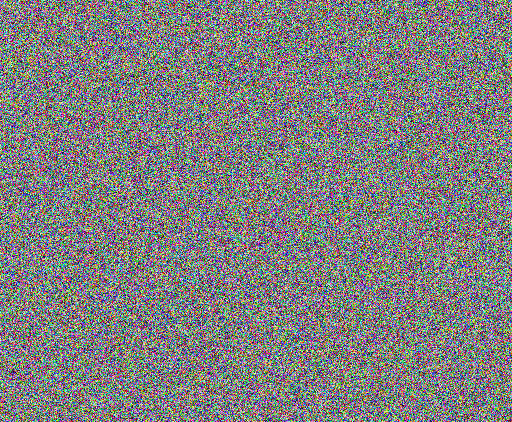

In [ ]:
image = tf.Variable(tf.random.uniform(style_image.shape,
                                      minval=0,
                                      maxval=1))

print(image.shape)

def clip_0_1(image):
  return tf.clip_by_value(image,
                          clip_value_min=0.0,
                          clip_value_max=1.0)
  
display.display(tensor_to_image(image[0]))

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

def style_loss(style_outputs):
    loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])    
    
    return loss

In [ ]:
class StyleModel(tf.keras.models.Model):
  def __init__(self, style_layers):
    super(StyleModel, self).__init__()
    self.vgg = vgg_layers(style_layers)
    self.style_layers = style_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    style_outputs = self.vgg(preprocessed_input)

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return style_dict

In [ ]:
extractor = StyleModel(style_layers)
style_targets = extractor(style_image)
print(len(style_targets))

1


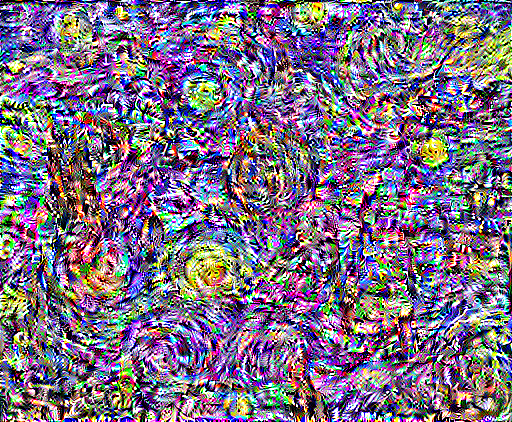

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Train step: 10000


In [ ]:
epochs = 100
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    with tf.GradientTape() as tape:
      outputs = extractor(image)
      loss = style_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))
    print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    if(step == 100 or step == 500 or step == 1000 or step == 2000 or step == 3000 or step == 5000 or step == 10000):
      file_name = 'style_loss_{}.png'.format(step)
      tensor_to_image(image[0]).save(file_name)

      try:
        from google.colab import files
      except ImportError:
        pass
      else:
        files.download(file_name)
    print("Train step: {}".format(step))